# CPU vs. GPU Implementations for K Matrix Assembly

In this notebook we investigate CPU runtime of 3 different methods for assembling the stiffness matrix K found in a linear finite element formulation

\begin{equation}
\mathbf{Ku}=\mathbf{f}
\end{equation}

The physical problem considered in this example is a steady-state thermal conduction problem with 2 different subdomains each generating heat power. This example is used primarily as a speed test for the following three stiffness matrix assembly implementations, but also to demonstrate the versatility of the ```EllipticFEM.jl``` package as well as the GPU counterpart implementations. Note that the ```sparse()``` matrix constructor is used for all implementations which requires three arrays to be provided: $\textit(I, J, V)$. These arrays are the indexing and value arrays, respectively, and are used to generate a COO, or coordinate list, matrix.

The first implementation is built on the ```EllipticFEM.jl``` package which was developed by Clemens Heitzinger and his research group at TU Wien in Vienna. This package consists of a set of types and funtions which allow users to define virtually any PDE (elliptic, parabolic, hyperbolic, etc.) with both constant and non-constant (varying in space and time) coefficients. 

The second implementation is a naive approach where each field in the ```meshData``` object is pushed to the GPU and operated on using the GPU. This implementation provides a simple interface with the ```EllipticFEM.jl``` package using the same or similar code to operate on the mesh data in order to construct the finite element matrices.  We consider this the naive implementation because several steps improvements can be made to make the code run faster (as discussed in the next implementation).

In the third implementation, we keep all fields in the ```meshData``` object on the CPU with the exception of the element and node data which is transfer to the GPU. The function ```assemble_MA_matrix_GPU_B()``` is called to perform this transfer as well as several simiplified computations to generate the I,J,V arrays. .

## Import Packages
Include ```ArrayFire.jl``` and ```EllipticFEM.jl``` packages as well as new types and functions needed to execute the above GPU implementation included in ```all_gpu_functions.jl```

In [53]:
#workspace()

# ArrayFire.jl package
using ArrayFire

# standard EllipticFEM types and functions
include("./EllipticFEM/src/EllipticFEM.jl")

# additional GPU types and functions
include("./gpu_added_functions/all_gpu_functions.jl")

computeFunctionValuesAtElementsCentroids_GPU (generic function with 1 method)

## Import Equation Data and Build Geometry
Here we import the PDE equation parameters from the file ```ellipticEquationData.jl``` and generate geometric and mesh structures containing the necessary information to formulate a Finite Element Model (FEM)

In [54]:
# Assemble equation data from input file 'ellipticEquationData.jl'
println("Assemble equationData...")
equationData = equationDataAssemble("./ellipticEquationData.jl")

# Assemble geometric data (points, lines, etc.)
println("Assemble geoData...")
geoData = equationDataToGeoData(equationData)

# Generate unstructured mesh
intendedMeshsize = 0.5
println("Assemble meshData...")
meshData = geoDataToMeshData(geoData,intendedMeshsize);

Assemble equationData...
Assemble geoData...
Assemble meshData...


Plot geoData...


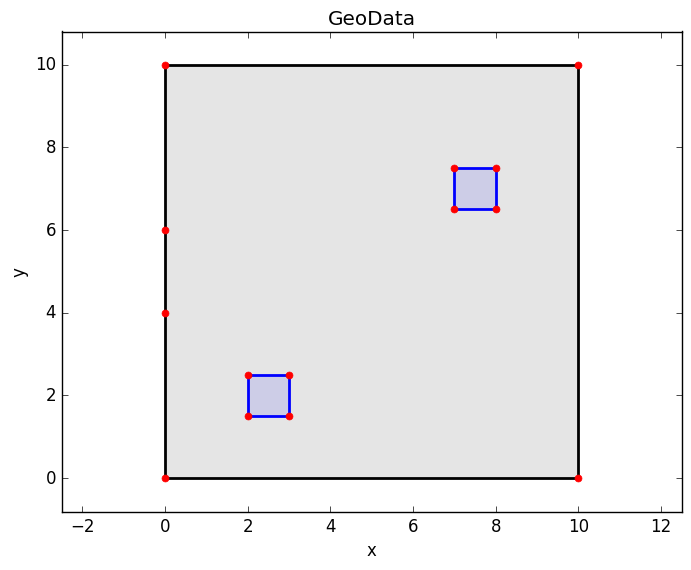

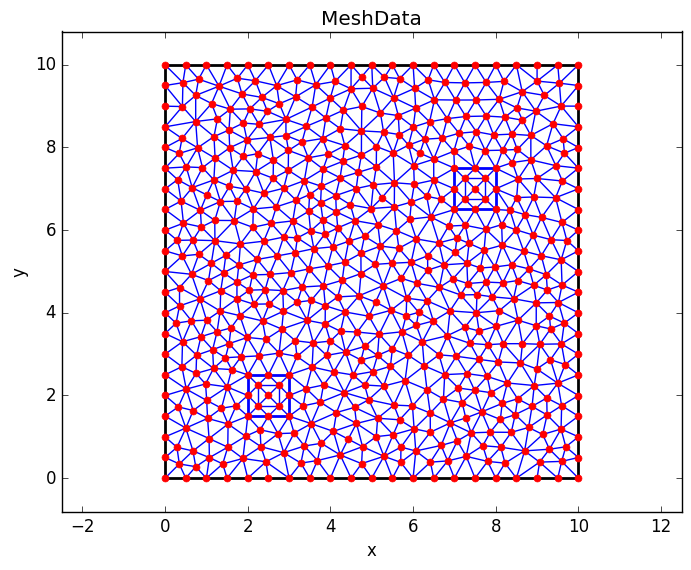

Plot meshData...


In [55]:
# Plot geometric data
println("Plot geoData...")
geoDataPlot(geoData)

println("Plot meshData...")
if intendedMeshsize >= 0.15
    meshDataPlotSlow(meshData)
else
    meshDataPlot(meshData)
end

## Compare assembly routines for single mesh
Here we compare the assembly routine ```lseDataAssembleMA.jl``` found in the ```EllipticFEM.jl``` package with the newly created GPU Implementations. We perform a single comparison over a mesh consisting of 13,385 nodes (13,385 DOFs).

In [56]:
# Define a mesh size (target size of element edge length)
intendedMeshsize = 0.1

0.1

In [57]:
# EllipticFEM.jl routine

# Assemble meshData
meshData = geoDataToMeshData_readOnly(geoData,intendedMeshsize)

# Assemble MA
MA_serial,elapsedTimes_serial = assemble_MA_matrix_serial(equationData,meshData)

println("Time to assemble I,J,V Arrays       : $(elapsedTimes_serial[1]) seconds")
println("Time to construct sparse matrix K   : $(elapsedTimes_serial[2]) seconds")

Time to assemble I,J,V Arrays       : 0.041843854 seconds
Time to construct sparse matrix K   : 0.007952847 seconds


In [58]:
#gc()

#path = "./Gmsh saved files/gmshData.msh"

#meshData_GPU = mshFileToMeshData_GPU(path)

#filehandle = open(path,"r")
#content = readdlm(filehandle)
#close(filehandle)

#i = findfirst(content,"\$Nodes")+2
#nodesNr = content[i-1,1]
#nodes = convert(Array{Float64,2},content[i:1:(i+nodesNr-1),2:1:3]')

#i = findfirst(content,"\$Elements")+2
#edgesAndElementsNr = content[i-1,1]
#rowIndicesEdges = findin(content[i:1:(i+edgesAndElementsNr-1),2],1)
#edges = convert(Array{Int64,2},content[i+rowIndicesEdges-1,[6,7]]')
#edgesParentGeoEdgesIds = convert(Array{Int64},content[i+rowIndicesEdges-1,5])
#edgesParentDomainsTypes = []
#edgesParentDomainsIds = []
#edgesParentGammasIds = []
#edgesParentGammasParameterRanges = []'
#edgesVolumes = zeros(size(edges,2),1)

#rowIndicesElements = findin(content[i:1:(i+edgesAndElementsNr-1),2],2)
#elements = convert(Array{Int64,2},content[i+rowIndicesElements-1,[6,7,8]]')
#elementsParentSubdomainsIntersectionsIds = convert(Array{Int64},content[i+rowIndicesElements-1,5])
#elementsParentDomainsTypes = []
#elementsParentDomainsIds = []
#elementsDetNablaFTs = zeros(size(elements,2),1)
#elementsNablaFTInv11s = zeros(size(elements,2),1)
#elementsNablaFTInv21s = zeros(size(elements,2),1)
#elementsNablaFTInv12s = zeros(size(elements,2),1)
#elementsNablaFTInv22s = zeros(size(elements,2),1)
#elementsVolumes = zeros(size(elements,2),1)
#elementsCentroids = zeros(size(elements,2),1)
#elementsMeshsizes = zeros(size(elements,2),1)

#iStart = findfirst(content,"\$Periodic")
#if iStart != 0

#    iStart += 1
#    iEnd = findfirst(content,"\$EndPeriodic")-1

#    rowIndices = (iStart-1) + findin(map(i->sum(map(x->typeof(x)==Int64,content[i,:])),iStart:1:iEnd),2)
#    periodicNodes = convert(Array{Int64,2},content[rowIndices,[2,1]]')

#else
#    periodicNodes = Array{Int64}(zeros(1,1))
#end
#AFArray(nodes)
#AFArray(edges)
#edgesParentGeoEdgesIds
#edgesParentDomainsTypes
#edgesParentDomainsIds
#edgesParentGammasIds
#edgesParentGammasParameterRanges
#AFArray(edgesVolumes)
#AFArray(elements)
#elementsParentSubdomainsIntersectionsIds
#elementsParentDomainsTypes
#elementsParentDomainsIds
#AFArray(elementsDetNablaFTs)
#AFArray(elementsNablaFTInv11s)
#AFArray(elementsNablaFTInv21s)
#AFArray(elementsNablaFTInv12s)
#AFArray(elementsNablaFTInv22s)
#AFArray(elementsVolumes)
#AFArray(elementsCentroids)
#AFArray(elementsMeshsizes)
#AFArray(periodicNodes)

#meshData_GPU = MeshData_GPU(AFArray(nodes),AFArray(edges),edgesParentGeoEdgesIds,edgesParentDomainsTypes,edgesParentDomainsIds,edgesParentGammasIds,edgesParentGammasParameterRanges,AFArray(edgesVolumes),AFArray(elements),elementsParentSubdomainsIntersectionsIds,elementsParentDomainsTypes,elementsParentDomainsIds,AFArray(elementsDetNablaFTs),AFArray(elementsNablaFTInv11s),AFArray(elementsNablaFTInv21s),AFArray(elementsNablaFTInv12s),AFArray(elementsNablaFTInv22s),AFArray(elementsVolumes),AFArray(elementsCentroids),AFArray(elementsMeshsizes),AFArray(periodicNodes))

#meshData_GPU.elementsMeshsizes = hcat( 
#((meshData_GPU.nodes[1,meshData_GPU.elements[2,:]]-meshData_GPU.nodes[1,meshData_GPU.elements[1,:]]).^2 + (meshData_GPU.nodes[2,meshData_GPU.elements[2,:]]-meshData_GPU.nodes[2,meshData_GPU.elements[1,:]]).^2).^0.5 , 
#((meshData_GPU.nodes[1,meshData_GPU.elements[3,:]]-meshData_GPU.nodes[1,meshData_GPU.elements[2,:]]).^2 + (meshData_GPU.nodes[2,meshData_GPU.elements[3,:]]-meshData_GPU.nodes[2,meshData_GPU.elements[2,:]]).^2).^0.5 , 
#((meshData_GPU.nodes[1,meshData_GPU.elements[1,:]]-meshData_GPU.nodes[1,meshData_GPU.elements[3,:]]).^2 + (meshData_GPU.nodes[2,meshData_GPU.elements[1,:]]-meshData_GPU.nodes[2,meshData_GPU.elements[3,:]]).^2).^0.5 )

In [59]:
#elements
#elementsNablaFTInv11s
#periodicNodes
#gc()
#elements2 = Array{Int64,2}(elements[:,1:683])
#elements2 = Array{Int32,2}(zeros(4096,1))
#elements3 = Array{Int32,2}(zeros(16385,1))
#elements4 = Array{Int64,2}(zeros(10000,1))
#AA = AFArray(elements2)
#BB = AFArray(elements3)
#DD = AFArray(elements4)
#CC = vcat(AA,BB)
#AFArray(rand(100,100))
#AFArray(rand(10000,1))
#deviceMemInfo()


#A = AFArray(ones(2,10))
#Array(A[1,3])

In [60]:
gc()
# GPU assembly routine A

# Assemble meshData (no longer calculating Jacobian entries)
meshData2,elapsedTimeInit = geoDataToMeshData_GPU(geoData,intendedMeshsize)

# Assemble MA
#I,J,V,elapsedTimes_GPU_A = assemble_MA_matrix_GPU_A(equationData,meshData2)
MA_GPU_A,elapsedTimes_GPU_A = assemble_MA_matrix_GPU_A(equationData,meshData2)

println("Time to push mesh data to GPU       : $(elapsedTimeInit) seconds")
println("Time to assemble I,J,V Arrays       : $(elapsedTimes_GPU_A[1]) seconds")
println("Time to push I,J,V data back to CPU : $(elapsedTimes_GPU_A[2]) seconds")
println("Time to construct sparse matrix K   : $(elapsedTimes_GPU_A[3]) seconds")

Time to push mesh data to GPU       : 0.04032487 seconds
Time to assemble I,J,V Arrays       : 0.058782727 seconds
Time to push I,J,V data back to CPU : 0.043065624 seconds
Time to construct sparse matrix K   : 0.00760047 seconds


In [61]:
#Array(I)[:]
#AAA = vcat( ((meshData_GPU.nodes[1,meshData_GPU.elements[2,:]]-meshData_GPU.nodes[1,meshData_GPU.elements[1,:]]).^2 + (meshData_GPU.nodes[2,meshData_GPU.elements[2,:]]-meshData_GPU.nodes[2,meshData_GPU.elements[1,:]]).^2).^0.5 , 
#((meshData_GPU.nodes[1,meshData_GPU.elements[3,:]]-meshData_GPU.nodes[1,meshData_GPU.elements[2,:]]).^2 + (meshData_GPU.nodes[2,meshData_GPU.elements[3,:]]-meshData_GPU.nodes[2,meshData_GPU.elements[2,:]]).^2).^0.5 , 
#((meshData_GPU.nodes[1,meshData_GPU.elements[1,:]]-meshData_GPU.nodes[1,meshData_GPU.elements[3,:]]).^2 + (meshData_GPU.nodes[2,meshData_GPU.elements[1,:]]-meshData_GPU.nodes[2,meshData_GPU.elements[3,:]]).^2).^0.5 )
#meshData_GPU.elements
#AAA
#maximum(AAA,1)

In [62]:
gc()
# GPU assembly routine B

# Assemble meshData (no longer calculating Jacobian entries)
meshData3 = geoDataToMeshData_readOnly(geoData,intendedMeshsize)

# Assemble MA
MA_GPU_B,elapsedTimes_GPU_B = assemble_MA_matrix_GPU_B(equationData,meshData3)

println("Time to push mesh data to GPU       : $(elapsedTimes_GPU_B[1]) seconds")
println("Time to assemble I,J,V Arrays       : $(elapsedTimes_GPU_B[2]) seconds")
println("Time to push I,J,V data back to CPU : $(elapsedTimes_GPU_B[3]) seconds")
println("Time to construct sparse matrix K   : $(elapsedTimes_GPU_B[4]) seconds")

Time to push mesh data to GPU       : 0.000379318 seconds
Time to assemble I,J,V Arrays       : 0.011044693 seconds
Time to push I,J,V data back to CPU : 0.04502807 seconds
Time to construct sparse matrix K   : 0.008377067 seconds


In [50]:
# Check to make sure that both stiffness matrices are the same

println("Maximum element difference between K_serial and K_GPU_A : $(maximum(MA_serial - MA_GPU_A))")
println("Maximum element difference between K_serial and K_GPU_B : $(maximum(MA_serial - MA_GPU_B))")
println("Sum over all element absolute differences between K_serial and K_GPU_A : $(sum(abs(MA_serial-MA_GPU_A)))")
println("Sum over all element absolute differences between K_serial and K_GPU_B : $(sum(abs(MA_serial-MA_GPU_B)))")


Maximum element difference between K_serial and K_GPU_A : 8.881784197001252e-16
Maximum element difference between K_serial and K_GPU_B : 8.881784197001252e-16
Sum over all element absolute differences between K_serial and K_GPU_A : 4.167711531791185e-12
Sum over all element absolute differences between K_serial and K_GPU_B : 4.167711531791185e-12


## Compare assembly routines for 10 different meshes of varying DOFs
Here we compare the assembly routine ```lseDataAssembleMA.jl``` found in the ```EllipticFEM.jl``` package with the newly created GPU Implementation. We perform a 10 comparisons over 10 different meshes consisting of sizes varying from 150 - 2.1M nodes (DOFs).  For each mesh size, we run 100 trials and average the runtimes

In [4]:
# Define array of mesh sizes (target size of element edge length)
testMeshSizes = [1.0]
#testMeshSizes = [1.0,0.5]
#testMeshSizes = [1.0,0.5,0.25,0.125,0.1,0.06125,0.03,0.01,0.0075]

meshDataArray = Array{Any}(length(testMeshSizes),1)
meshDataArray_GPU = Array{Any}(length(testMeshSizes),1)
nDOFsArray = zeros(length(testMeshSizes),1)
nDOFsArray_GPU = zeros(length(testMeshSizes),1)

#for m = 1:length(testMeshSizes)
#    meshDataArray[m] = geoDataToMeshData_readOnly(geoData,testMeshSizes[m])
#    nDOFs[m] = size(meshDataArray[m].nodes,2)
#end

1x1 Array{Float64,2}:
 0.0

In [5]:
# number of trials for each run
nTrials = 100

# elapsedTime array for CPU runs
elapsedTimeTrials_CPU = zeros(2,nTrials+1,length(testMeshSizes))

# elapsedTime array for GPU A runs
elapsedTimeTrials_GPU_A = zeros(4,nTrials+1,length(testMeshSizes));

# elapsedTime array for GPU B runs
elapsedTimeTrials_GPU_B = zeros(4,nTrials+1,length(testMeshSizes));

### CPU Implementation Time Trials

In [ ]:
gc()
for m in 1:length(testMeshSizes)
 
    # Assemble meshData
    meshData = geoDataToMeshData_readOnly(geoData,testMeshSizes[m])
    meshDataArray[m] = meshData
    
    # Store the number of DOFs
    nDOFs = size(meshData.nodes,2)
    nDOFsArray[m] = nDOFs
    
    for i in 1:nTrials+1
        
        # Assemble MA
        MA_serial,elapsedTimes_serial = assemble_MA_matrix_serial(equationData,meshData)
    
        elapsedTimeTrials_CPU[1,i,m] = elapsedTimes_serial[1]
        elapsedTimeTrials_CPU[2,i,m] = elapsedTimes_serial[2]
    end
end

In [ ]:
finalT_CPU = zeros(2,length(testMeshSizes))
for k = 1:length(testMeshSizes)
    finalT_CPU[:,k] = sum(elapsedTimeTrials_CPU[:,2:end,k],2)./nTrials
end

In [ ]:
for kk = 1:length(testMeshSizes)
    println("Mesh Size: $(nDOFsArray[kk])")
    println("Average time to build I,J,V arrays : $(finalT_CPU[1,kk]) seconds")
    println("Average time to build matrix K     : $(finalT_CPU[2,kk]) seconds")
    println("")
end

writedlm("CPU_nDOFs.txt",nDOFsArray)
writedlm("CPU_runtimes.txt",finalT_CPU)

### GPU Implementation A Time Trials

In [9]:
gc()
for m in 1:length(testMeshSizes)
    
    # Assemble meshData
    meshData_GPU,elapsedTimeInit = geoDataToMeshData_GPU(geoData,testMeshSizes[m])
    meshDataArray_GPU[m] = meshData
    
    # Store the number of DOFs
    nDOFs = size(meshData_GPU.nodes,2)
    nDOFsArray_GPU[m] = nDOFs
    
    for i in 1:nTrials+1
        
        # Assemble MA
        MA_GPU_A,elapsedTimes_GPU_A = assemble_MA_matrix_GPU_A(equationData,meshData_GPU)
    
        elapsedTimeTrials_GPU_A[1,i,m] = elapsedTimeInit
        elapsedTimeTrials_GPU_A[2,i,m] = elapsedTimes_GPU_A[1]
        elapsedTimeTrials_GPU_A[3,i,m] = elapsedTimes_GPU_A[2]
        elapsedTimeTrials_GPU_A[4,i,m] = elapsedTimes_GPU_A[3]
    end
end

In [10]:
finalT_GPU_A = zeros(4,length(testMeshSizes))
for k = 1:length(testMeshSizes)
    finalT_GPU_A[:,k] = sum(elapsedTimeTrials_GPU_A[:,2:end,k],2)./nTrials
end

In [11]:
for kk = 1:length(testMeshSizes)
    println("Mesh Size: $(nDOFsArray_GPU[kk])")
    println("Average time to push CPU -> GPU    : $(finalT_GPU_A[1,kk]) seconds")
    println("Average time to build I,J,V arrays : $(finalT_GPU_A[2,kk]) seconds")
    println("Average time to push GPU -> CPU    : $(finalT_GPU_A[3,kk]) seconds")
    println("Average time to build matrix K     : $(finalT_GPU_A[4,kk]) seconds")
    println("")
end

writedlm("GPU_A_nDOFs.txt",nDOFsArray_GPU)
writedlm("GPU_A_runtimes.txt",finalT_GPU_A)

Mesh Size: 150.0
Average time to push CPU -> GPU    : 0.050601091999999966 seconds
Average time to build I,J,V arrays : 0.02069820998999999 seconds
Average time to push GPU -> CPU    : 0.0007534271700000002 seconds
Average time to build matrix K     : 5.410947999999997e-5 seconds



### GPU Implementation B Time Trials

In [ ]:
gc()
for m in 1:length(testMeshSizes)
    
    # Assemble meshData
    meshData = geoDataToMeshData_readOnly(geoData,testMeshSizes[m])
    meshDataArray[m] = meshData
    
    # Store the number of DOFs
    nDOFs = size(meshData.nodes,2)
    nDOFsArray[m] = nDOFs
    
    for i in 1:nTrials+1
        
        # Assemble MA
        MA_GPU_B,elapsedTimes_GPU_B = assemble_MA_matrix_GPU_B(equationData,meshData)
    
        elapsedTimeTrials_GPU_B[1,i,m] = elapsedTimes_GPU_B[1]
        elapsedTimeTrials_GPU_B[2,i,m] = elapsedTimes_GPU_B[2]
        elapsedTimeTrials_GPU_B[3,i,m] = elapsedTimes_GPU_B[3]
        elapsedTimeTrials_GPU_B[4,i,m] = elapsedTimes_GPU_B[4]
    end
end

In [ ]:
finalT_GPU_B = zeros(4,length(testMeshSizes))
for k = 1:length(testMeshSizes)
    finalT_GPU_B[:,k] = sum(elapsedTimeTrials_GPU_B[:,2:end,k],2)./nTrials
end

In [ ]:
for kk = 1:length(testMeshSizes)
    println("Mesh Size: $(nDOFsArray[kk])")
    println("Average time to push CPU -> GPU    : $(finalT_GPU_B[1,kk]) seconds")
    println("Average time to build I,J,V arrays : $(finalT_GPU_B[2,kk]) seconds")
    println("Average time to push GPU -> CPU    : $(finalT_GPU_B[3,kk]) seconds")
    println("Average time to build matrix K     : $(finalT_GPU_B[4,kk]) seconds")
    println("")
end

writedlm("GPU_B_nDOFs.txt",nDOFsArray)
writedlm("GPU_B_runtimes.txt",finalT_GPU_B)

In [12]:
nDOFsArray

1x1 Array{Float64,2}:
 0.0